In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.spatial.distance import cdist
import cv2
import sys
import pandas as pd
from IPython.display import display
from datetime import datetime

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from photutils.aperture import ApertureStats, aperture_photometry, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder, find_peaks
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import vstack, Table, Column
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

sys.path.append('/home/finn/visual_Studio_Code/bachelorarbeit/')
from phot_used_functions import filter_sources, determine_distance, determine_shift, determine_magnitudes, determine_fwhm
from phot_used_functions import import_images
from plotting import show_image

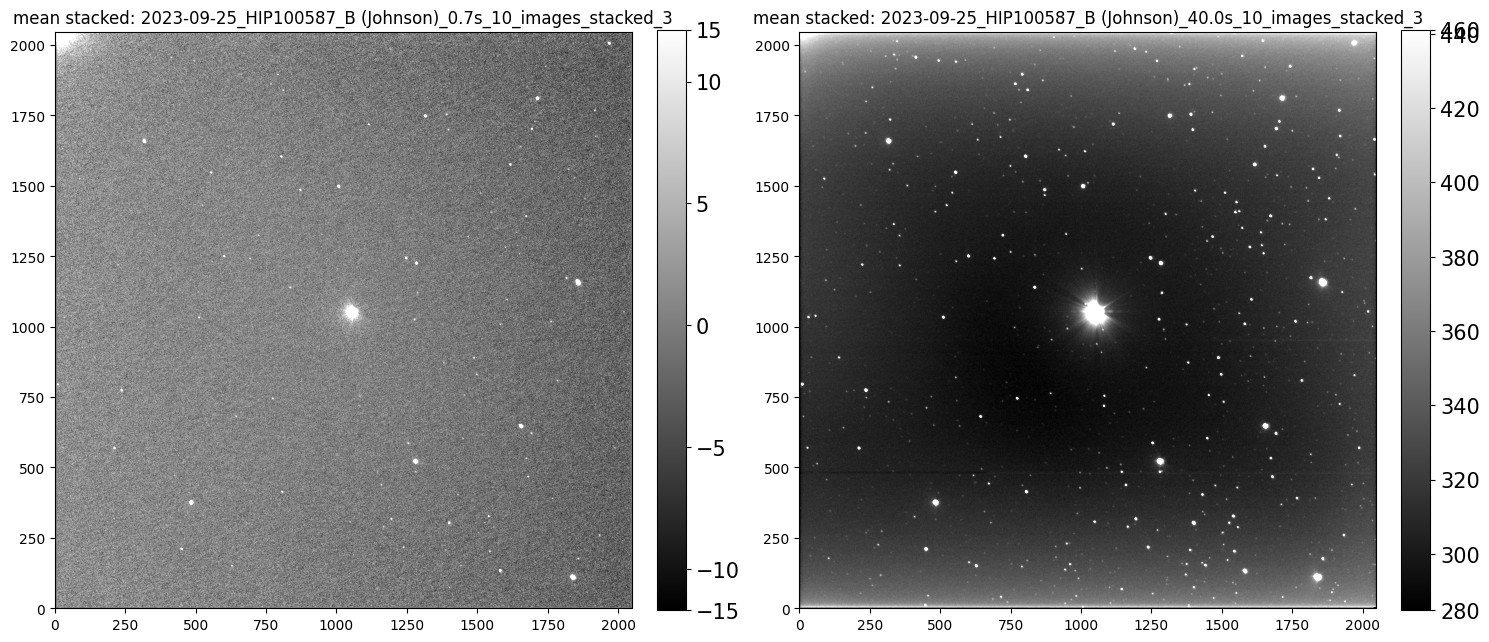

In [2]:
## from phot_used_functions import import_images
path_short        ='/home/finn/visual_Studio_Code/data/2023-09-25/stacked/lightCor_HIP100587_B (Johnson)_0.7s_10_images_stacked_0.fit'
path_long         ='/home/finn/visual_Studio_Code/data/2023-09-25/stacked/lightCor_HIP100587_B (Johnson)_40.0s_10_images_stacked_0.fit'
path_short_median ='/home/finn/visual_Studio_Code/data/2023-09-25/stacked_old/lightCor_HIP100587_B (Johnson)_0.7s_long-short-series_10_images_stacked_0.fit'
path_long_median  ='/home/finn/visual_Studio_Code/data/2023-09-25/stacked_old/lightCor_HIP100587_B (Johnson)_40.0s_long-short-series_10_images_stacked_0.fit'

image_list_long,  header_list_long, titles_long, exptime_long = import_images(path_long)
image_list_short, header_list_short, titles_short, exptime_short = import_images(path_short)
image_list_long_median, header_list_long_median, titles_long_median, exptime_long_median = import_images(path_long_median)
image_list_short_median, header_list_short_median, titles_short_median, exptime_short_median = import_images(path_short_median)

middle = len(image_list_short)//2
image_short = image_list_short_median[middle]
image_long = image_list_long_median[middle]

w_short = WCS(header_list_short[middle]) 
w_long = WCS(header_list_long[middle])


fig, ax = plt.subplots(1, 2, figsize=(15, 30))
show_image(image_short, fig=fig, ax=ax[0])
show_image(image_long , fig=fig, ax=ax[1])
ax[0].set_title(f'mean stacked: {titles_short[middle]}')
ax[1].set_title(f'mean stacked: {titles_long[middle]}')
plt.tight_layout()

In [3]:
time_list =[]
for i in range (len(header_list_long)):
    print(header_list_long[i]['DATE-OBS'])
    time_list.append(header_list_long[i]['DATE-OBS'])

output_path = path_short[:46] + 'results'
if not os.path.exists(output_path):
    os.makedirs(output_path)

file_name = f'time_list_{header_list_short[0]["DATE-OBS"][:10]}_ls_{header_list_short[0]["OBJECT"]}_{header_list_short[0]["FILTER"]}.txt'
file_path = os.path.join(output_path, file_name) 
with open(file_path, 'w') as file:
    for item in time_list:
        file.write(f"{item}\n")

2023-09-25T19:02:49
2023-09-25T19:12:08
2023-09-25T19:21:26
2023-09-25T19:30:41
2023-09-25T19:39:57
2023-09-25T19:49:19
2023-09-25T19:58:39


In [3]:
# determine the shifts between images (other version at bottom of document)
shifts_long = determine_shift(image_list_long_median)
print(shifts_long)

Number of images to process: 7
we use image:  3 from given list as reference image


[(-3.22699, -0.46748975), (-56.84429, -26.464834), (-18.27333, -8.5458555), (0, 0), (22.589134, 8.672929), (36.56433, 18.316496), (63.524822, 22.466795)]


In [ ]:
radius_bright = 45 ############## change apperture_radius here 
def get_mag_bright(image_list, apperture_radius=60):

    positions_bright, magnitude_list_bright = [], []
    mean, median, std = sigma_clipped_stats(image_list[middle], sigma=3.0)
    daofind = DAOStarFinder(fwhm=5.0, threshold=5.0*std, roundlo=-5.0, roundhi=5.0,brightest=1) #roundlo and roundhi to adjust detection shape. need to be
    sources = daofind(image_list[middle])
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    #positions = [(993.1, 1017.3)] # used clicker for this time, in gerenall use starfinder
    for i, image in enumerate(image_list):
        shifted_positions = []
        for position in positions:
                tuple = np.array((position[0]+shifts_long[i][0], position[1]+shifts_long[i][1]))
                shifted_positions.append(tuple)
 
        if i == 1:
            fig, ax = plt.subplots(1,1, figsize=(10,10))
        else: 
            fig, ax = plt.subplots(1,1, figsize=(6,6))
        show_image(image, fig=fig, ax=ax, percl=99.5, show_ticks=False, fs_colorbar=16, cmap='gray', arrow_color='black', scale=True, north_arrow=True, east_arrow=True)
        #ax.set_title(titles_short[i])
        magnitudes = determine_magnitudes(image, positions=shifted_positions, star_radius=apperture_radius, exptime=exptime_short, lw=1.0, alpha=0.6)
        magnitude_list_bright.append(magnitudes)
        positions_bright.append(shifted_positions)
    print(magnitude_list_bright)
    print(np.std(magnitude_list_bright))
    print(positions_bright)
    return positions_bright, magnitude_list_bright

pos_br_median, mag_br_median = get_mag_bright(image_list_short_median, apperture_radius=radius_bright)
pos_br_mean, mag_br_mean = get_mag_bright(image_list_short, apperture_radius=radius_bright)

In [ ]:
top_n = 300 # change here !!!

def get_mag_faint(image_list, plotting=False):
    magnitude_list_faint, positions_faint = [], []

    mask = np.zeros(image_long.shape, dtype=bool)
    x, y = np.ogrid[:image_long.shape[1], :image_long.shape[0]]
    circle_mask = np.sqrt((x - pos_br_median[middle][0][1]) ** 2 + (y - pos_br_median[middle][0][0]) ** 2) <= (radius_bright+130)
    mask[circle_mask] = True

    mean, median, std = sigma_clipped_stats(image_long, sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0, threshold=2*std, roundlo=-5.0, roundhi=5.0) #roundlo and roundhi to adjust detection shape. need to be calibrated
    sources = daofind(image_long, mask=mask) #use image_long =middle image form median stacked
    sources.sort(['xcentroid', 'ycentroid'])
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    # Exclude multiple detections and stars which are to close to edge or each other (keep the brightest star)
    positions,sources = filter_sources(positions, sources, min_edge_distance=60)
    #determine individual radii for apertures
    valid_positions, fwhm = determine_fwhm(image_long, positions,max_value=8) ##change max value later
    radii = [value * 3 for value in fwhm]  # aperture size should be 3 * FWHM
    print(np.mean(radii))
    #valid_positions = positions
    #radii = 14 * np.ones(len(positions))


    for i,image in enumerate (image_list):

        shifted_positions = []
        if i == 0: # for the first image use the pre determined pos
            for position in valid_positions:
                tuple = np.array((position[0]+shifts_long[i][0], position[1]+shifts_long[i][1]))
                shifted_positions.append(tuple)
        else:
            for position in positions_faint[0]: # because we choose top_n in first image we need to stick to these positons, otherwise we would determine top_n new in everimage -> usage of different ref stars
                tuple = np.array((position[0]+shifts_long[i][0]-shifts_long[0][0], position[1]+shifts_long[i][1]-shifts_long[0][1])) # -shifts[0] because positions_faint already shifted
                #tuple = np.array((position[0], position[1]))
                shifted_positions.append(tuple)

        apertures_faint = [CircularAperture(position, r=r) for position, r in zip(shifted_positions, radii)]
        annulus_apertures_faint = [CircularAnnulus(position,r_in=radius+5, r_out=radius+15) for position,radius in zip(shifted_positions,radii)]



        # Initialize an empty table to store the photometry results
        phot_table_faint = Table(names=('id', 'xcenter', 'ycenter', 'aperture_sum', 'total_bkg'), dtype=('int', 'float', 'float', 'float', 'float'))
        for j in range(len(apertures_faint)):
            aperstats = ApertureStats(image, annulus_apertures_faint[j])
            bkg = aperstats.median
            aperture_area = apertures_faint[j].area_overlap(image)
            total_bkg = bkg * aperture_area
            phot_table = aperture_photometry(image, apertures_faint[j])
            phot_table['total_bkg'] = total_bkg
            phot_table_faint.add_row([j, phot_table['xcenter'][0], phot_table['ycenter'][0], phot_table['aperture_sum'][0], phot_table['total_bkg'][0]])
        magnitudes=[]
        for row in phot_table_faint:
            magnitude =  - (2.5 * np.log10(abs(row['aperture_sum'] - row['total_bkg']) / exptime_long))
            magnitudes.append(magnitude)
        

        sorted_indices = np.argsort(magnitudes)[:top_n]
        top_n_magnitudes = [magnitudes[idx] for idx in sorted_indices]
        top_n_positions = [shifted_positions[idx] for idx in sorted_indices]
        apertures_faint = [apertures_faint[idx] for idx in sorted_indices]
        annulus_apertures_faint = [annulus_apertures_faint[idx] for idx in sorted_indices]
        
        magnitude_list_faint.append(top_n_magnitudes)
        positions_faint.append(top_n_positions)

        if plotting == True:
            fig, ax = plt.subplots(1,1, figsize = (10,10))
            show_image(image, fig=fig, ax=ax, percl=99.5, show_ticks=False, fs_colorbar=16, cmap='gray', arrow_color='white', scale=True, north_arrow=True, east_arrow=True)
            #ax.set_title(titles_long[i])
            for aperture in apertures_faint:
                aperture.plot(color="red", lw=1.0, alpha=0.6)
            for anulus in annulus_apertures_faint:
                anulus.plot(color="blue", lw=1.0, alpha=0.6)

    mean_faint_magnitudes_list = [np.mean(mag) for mag in magnitude_list_faint] #mean of all refernce stars
    print(mean_faint_magnitudes_list)
    print(np.std(mean_faint_magnitudes_list))
    return positions_faint, magnitude_list_faint, mean_faint_magnitudes_list

#pos_ft_mean,    mag_ft_mean,    mean_mag_ft_mean    = get_mag_faint(image_list_long, plotting=False)
pos_ft_median,  mag_ft_median,  mean_mag_ft_median  = get_mag_faint(image_list_long_median, plotting=True)
print(len(pos_ft_median[0]))

In [75]:
def print_results(magnitude_list_bright,mean_faint_magnitudes_list):
  diff_magnitude_list = []
  #print("index  bright mag        faint mag         diff mag")
  for index in range (len(image_list_short)):
    diff_magnitude= magnitude_list_bright[index] - mean_faint_magnitudes_list [index]
    #print(index,  magnitude_list_bright[index] , mean_faint_magnitudes_list [index], diff_magnitude)
    diff_magnitude_list.append(diff_magnitude)
  print("The differential  Magnitude is: M = $", round(np.mean(diff_magnitude_list),4),"\pm",round(np.std(diff_magnitude_list),4),"$")
  print(f"Value for bright star: {round(np.mean(magnitude_list_bright),4)}+-{round(np.std(magnitude_list_bright),4)}")
  print(f"Value for faint stars: {round(np.mean(mean_faint_magnitudes_list),4)}+-{round(np.std(mean_faint_magnitudes_list),4)}")
  
print('for median:')
print_results(mag_br_median,  mean_mag_ft_median)
print('')
print('for mean:')
print_results(mag_br_mean,  mean_mag_ft_mean)

for median:
The differential  Magnitude is: M = $ -9.5376 \pm 0.7563 $
Value for bright star: -14.6485+-2.2692
Value for faint stars: -5.1108+-1.5148

for mean:
The differential  Magnitude is: M = $ -9.5684 \pm 0.6909 $
Value for bright star: -14.6939+-2.2208
Value for faint stars: -5.1255+-1.5307


In [76]:
# for bright position
# no need to do it seperatly for mean and median, because positions are same (and only wcs information for mean)
bright_results = []
empty_column = Column(name='Position Number', data=[None])
x_column = Column(name='x', data=[None])
y_column = Column(name='y', data=[None])

sky = w_short.pixel_to_world(*pos_br_mean[middle][0]) # for only one image 
print(sky)
star_coords = SkyCoord(ra=sky.ra, dec=sky.dec, frame='icrs', unit=(u.deg, u.deg))

viz = Vizier(columns=['DR3Name', 'RAJ2000', 'DEJ2000', 'BPmag','e_BPmag', 'RPmag', 'e_RPmag', 'Gmag', 'Plx','e_Plx', 'G-RP', 'BP-RP']) # params for gaia: Gmag: phot_g_mean_mag, Plx: parallax [mas], G-RP: Gmag-Rmag
result = viz.query_region(star_coords, radius=10 * u.arcsecond, catalog='I/355 ') #gaia dr3

# Check and select the entry with the lowest magnitude
if result is not None and len(result) > 0:
    min_mag_idx = None
    min_mag = float('inf')

    # Find the entry with the lowest magnitude
    for idx, row in enumerate(result[0]):
        if row['BPmag'] < min_mag:
            min_mag = row['BPmag']
            min_mag_idx = idx
        if row['RPmag'] < min_mag:
            min_mag = row['RPmag']
            min_mag_idx = idx

    # If a minimum magnitude entry is found, update the values
    if min_mag_idx is not None:
        # Use .copy() to avoid modifying the original columns
        result[0]['Position Number'] = empty_column.copy()
        result[0]['x'] = x_column.copy()
        result[0]['y'] = y_column.copy()
        # Update the values for the current iteration
        result[0]['Position Number'][min_mag_idx] = len(pos_ft_mean[0])+1 #give it the last number, because we will combine with faint list
        result[0]['x'][min_mag_idx] = pos_br_mean[middle][0][0]
        result[0]['y'][min_mag_idx] = pos_br_mean[middle][0][1]

        bright_results.append(result[0][min_mag_idx])

print(bright_results)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (305.9656551, 32.19027566)>


[<Row index=1>
          DR3Name                RAJ2000         DEJ2000       BPmag    e_BPmag    RPmag    e_RPmag     Gmag      Plx     e_Plx     G-RP     BP-RP   Position Number         x                  y         
                                   deg             deg          mag       mag       mag       mag       mag       mas      mas      mag       mag                                                         
           str28                 float64         float64      float64   float64   float64   float64   float64   float64  float32  float64   float64       object           object             object      
---------------------------- --------------- --------------- --------- --------- --------- --------- --------- --------- ------- --------- --------- --------------- ------------------ ------------------
Gaia DR3 1862193748217511040 305.96505748925  32.19013378977  4.689272  0.003562  3.181613  0.004281  3.972560   12.2359  0.1273  0.790946  1.507659             228 1054.546

In [77]:
# for faint position 
# here no need to it seperatly too
all_results = []
empty_column = Column(name='Position Number', data=[None])
x_column = Column(name='x', data=[None])
y_column = Column(name='y', data=[None])

for i, position in enumerate(pos_ft_mean[middle]):
    sky = w_long.pixel_to_world(*position)
    star_coords = SkyCoord(ra=sky.ra, dec=sky.dec, frame='icrs', unit=(u.deg, u.deg))

    viz = Vizier(columns=['DR3Name', 'RAJ2000', 'DEJ2000', 'BPmag','e_BPmag', 'RPmag', 'e_RPmag', 'Gmag', 'Plx','e_Plx', 'G-RP', 'BP-RP']) # params for gaia
    result = viz.query_region(star_coords, radius= 5.0 * u.arcsecond, catalog='I/355 ') #gaia dr3

    # Check and select the entry with the lowest magnitude
    if result is not None and len(result) > 0:
        min_mag_idx = None
        min_mag = float('inf')

        # Find the entry with the lowest magnitude
        for idx, row in enumerate(result[0]):
            if row['BPmag'] < min_mag:
                min_mag = row['BPmag']
                min_mag_idx = idx
            if row['RPmag'] < min_mag:
                min_mag = row['RPmag']
                min_mag_idx = idx

        # If a minimum magnitude entry is found, update the values
        if min_mag_idx is not None:
            # Use .copy() to avoid modifying the original columns
            result[0]['Position Number'] = empty_column.copy()
            result[0]['x'] = x_column.copy()
            result[0]['y'] = y_column.copy()
            # Update the values for the current iteration
            result[0]['Position Number'][min_mag_idx] = i + 1
            result[0]['x'][min_mag_idx] = position[0]
            result[0]['y'][min_mag_idx] = position[1]

            all_results.append(result[0][min_mag_idx])

print(len(all_results))

227


In [89]:
final_table_gaia = vstack(all_results + bright_results)
df = final_table_gaia.to_pandas()
display(df)

,DR3Name,RAJ2000,DEJ2000,BPmag,e_BPmag,RPmag,e_RPmag,Gmag,Plx,e_Plx,G-RP,BP-RP,Position Number,x,y
0,Gaia DR3 1862199005254756736,306.139069,32.207997,9.239444,0.002806,8.508635,0.003789,8.957806,7.6569,0.0132,0.449171,0.730809,1,1856.711827,1152.655887
1,Gaia DR3 1862187907058841088,306.133825,32.016689,9.365703,0.002817,9.154440,0.003789,9.297263,3.7787,0.0298,0.142823,0.211263,2,1837.067222,111.549718
2,Gaia DR3 1862190861985484800,306.013421,32.092404,9.214108,0.002835,8.747530,0.003869,9.135907,4.3259,0.0354,0.388377,0.466578,3,1279.791597,521.029895
3,Gaia DR3 1862097639709884928,305.840992,32.066135,9.359471,0.002806,8.217300,0.003795,8.869079,2.0784,0.0152,0.651778,1.142171,4,484.016398,374.614025
4,Gaia DR3 1862189418887387136,306.094658,32.115188,9.484606,0.002824,7.999590,0.003793,8.797172,2.1007,0.0144,0.797582,1.485016,5,1653.413485,646.039852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Gaia DR3 1862193159784077952,306.047901,32.183286,15.990137,0.003519,14.496512,0.003918,15.331759,0.6883,0.0274,0.835247,1.493625,224,1435.84742,1015.243611
224,Gaia DR3 2054348076771674368,305.996780,32.269242,16.450113,0.003794,15.155223,0.003954,15.881533,0.6712,0.0308,0.726310,1.294890,225,1198.808979,1482.441055
225,Gaia DR3 2054351753263747456,305.875212,32.292917,16.293499,0.004339,14.667687,0.004284,15.537233,0.2622,0.0260,0.869546,1.625812,226,638.384811,1609.400877
226,Gaia DR3 1862187013705699840,306.018656,32.012316,16.565520,0.004790,15.104181,0.004558,15.920992,0.3061,0.0349,0.816811,1.461338,227,1304.954947,84.556046


In [90]:
valid_positions = df['Position Number'].to_list()
print(valid_positions)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [91]:
#combine the faint and bright magnitudes (for saving them into table later)
mag_all_mean    = [ft + [br] for ft, br in zip(mag_ft_mean, mag_br_mean)]
mag_all_median  = [ft + [br] for ft, br in zip(mag_ft_median, mag_br_median)]

print(mag_all_mean[0][-1])
print(len(mag_all_mean[0]))

-9.26031877308514
228


In [92]:
#only save the magnitudes from the positions which are solved with gaia data
valid_mag_mean   = []
valid_mag_median = []
for i in range (len(mag_all_mean)):
    m1=[]
    m2=[]
    for index in valid_positions:
        m1.append(mag_all_mean[i][index-1])
        m2.append(mag_all_median[i][index-1])
    valid_mag_mean.append(m1)
    valid_mag_median.append(m2)

print(valid_positions)
print(mag_all_median)
print(valid_mag_median)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [93]:
for i, mag_list in enumerate(valid_mag_mean):
    col_name = f'Mag_Mean_Im_{i+1}'  # create coloumn for each image
    df = df.assign(**{col_name: mag_list})  # Add magnitudes for the current image to the DataFrame

for i, mag_list in enumerate(valid_mag_median):
    col_name = f'Mag_Median_Im_{i+1}'  # create coloumn for each image
    df = df.assign(**{col_name: mag_list}) 

display(df)

,DR3Name,RAJ2000,DEJ2000,BPmag,e_BPmag,RPmag,e_RPmag,Gmag,Plx,e_Plx,...,Mag_Mean_Im_5,Mag_Mean_Im_6,Mag_Mean_Im_7,Mag_Median_Im_1,Mag_Median_Im_2,Mag_Median_Im_3,Mag_Median_Im_4,Mag_Median_Im_5,Mag_Median_Im_6,Mag_Median_Im_7
0,Gaia DR3 1862199005254756736,306.139069,32.207997,9.239444,0.002806,8.508635,0.003789,8.957806,7.6569,0.0132,...,-11.353791,-11.627868,-11.584164,-11.391839,-11.593069,-11.578285,-11.406929,-11.294122,-11.627477,-11.577101
1,Gaia DR3 1862187907058841088,306.133825,32.016689,9.365703,0.002817,9.154440,0.003789,9.297263,3.7787,0.0298,...,-11.292759,-11.571895,-11.502045,-7.057723,-11.547236,-11.511369,-11.321426,-11.218335,-11.568560,-11.495876
2,Gaia DR3 1862190861985484800,306.013421,32.092404,9.214108,0.002835,8.747530,0.003869,9.135907,4.3259,0.0354,...,-11.229855,-11.524175,-11.462304,-6.879369,-11.499291,-11.476479,-11.275088,-11.151896,-11.521235,-11.463082
3,Gaia DR3 1862097639709884928,305.840992,32.066135,9.359471,0.002806,8.217300,0.003795,8.869079,2.0784,0.0152,...,-10.770258,-11.078481,-11.040541,-6.741556,-11.078068,-11.021978,-10.810086,-10.696895,-11.072345,-11.032804
4,Gaia DR3 1862189418887387136,306.094658,32.115188,9.484606,0.002824,7.999590,0.003793,8.797172,2.1007,0.0144,...,-10.352133,-10.648813,-10.619367,-6.067988,-10.572655,-10.555103,-10.363687,-10.251839,-10.612166,-10.582473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Gaia DR3 1862193159784077952,306.047901,32.183286,15.990137,0.003519,14.496512,0.003918,15.331759,0.6883,0.0274,...,-3.647350,-3.911646,-3.860080,2.663758,-3.939151,-3.855127,-3.710457,-3.442863,-3.889530,-3.932687
224,Gaia DR3 2054348076771674368,305.996780,32.269242,16.450113,0.003794,15.155223,0.003954,15.881533,0.6712,0.0308,...,-3.605744,-3.910375,-3.788624,2.771149,-3.767632,-3.721654,-3.601445,-3.402796,-3.844631,-3.738270
225,Gaia DR3 2054351753263747456,305.875212,32.292917,16.293499,0.004339,14.667687,0.004284,15.537233,0.2622,0.0260,...,-3.605533,-3.854588,-3.653589,3.347272,-3.516909,-3.660051,-3.430015,-3.356310,-3.824939,-3.733361
226,Gaia DR3 1862187013705699840,306.018656,32.012316,16.565520,0.004790,15.104181,0.004558,15.920992,0.3061,0.0349,...,-3.174961,-3.760328,-3.382619,3.837913,-3.457571,-3.440917,-3.420582,-2.987990,-3.718222,-3.543575


In [83]:
#save to csv file
file_name = 'results_' + titles_long[0][:74] +'_r_gaia=5.csv'
file_path = os.path.join(output_path, file_name) #output path defined above
df.to_csv(file_path)